In [1]:
from astropy.modeling import models, fitting
from astropy.modeling.functional_models import Gaussian2D
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# MagAO-X epoch

/Users/loganpearce/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


3538215.0 246 242


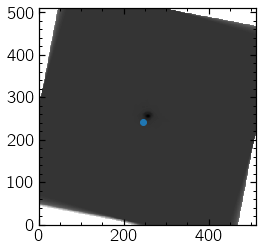

In [2]:
# Open cube of rotated and registered images:
filt = 'z'
im = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_summed.fits')

initial_guess = np.array([246.375 - 1, 242.818 - 1])
initial_guess = np.array([int(initial_guess[0]+1),int(initial_guess[1]+1)])

%matplotlib inline
plt.imshow(np.log10(im), cmap='Greys', origin='lower')
plt.scatter(*initial_guess)
print(im[int(initial_guess[1]),int(initial_guess[0])], int(initial_guess[0]),int(initial_guess[1]))

1.8124857281083697 0.7712705225993063


<IPython.core.display.Javascript object>


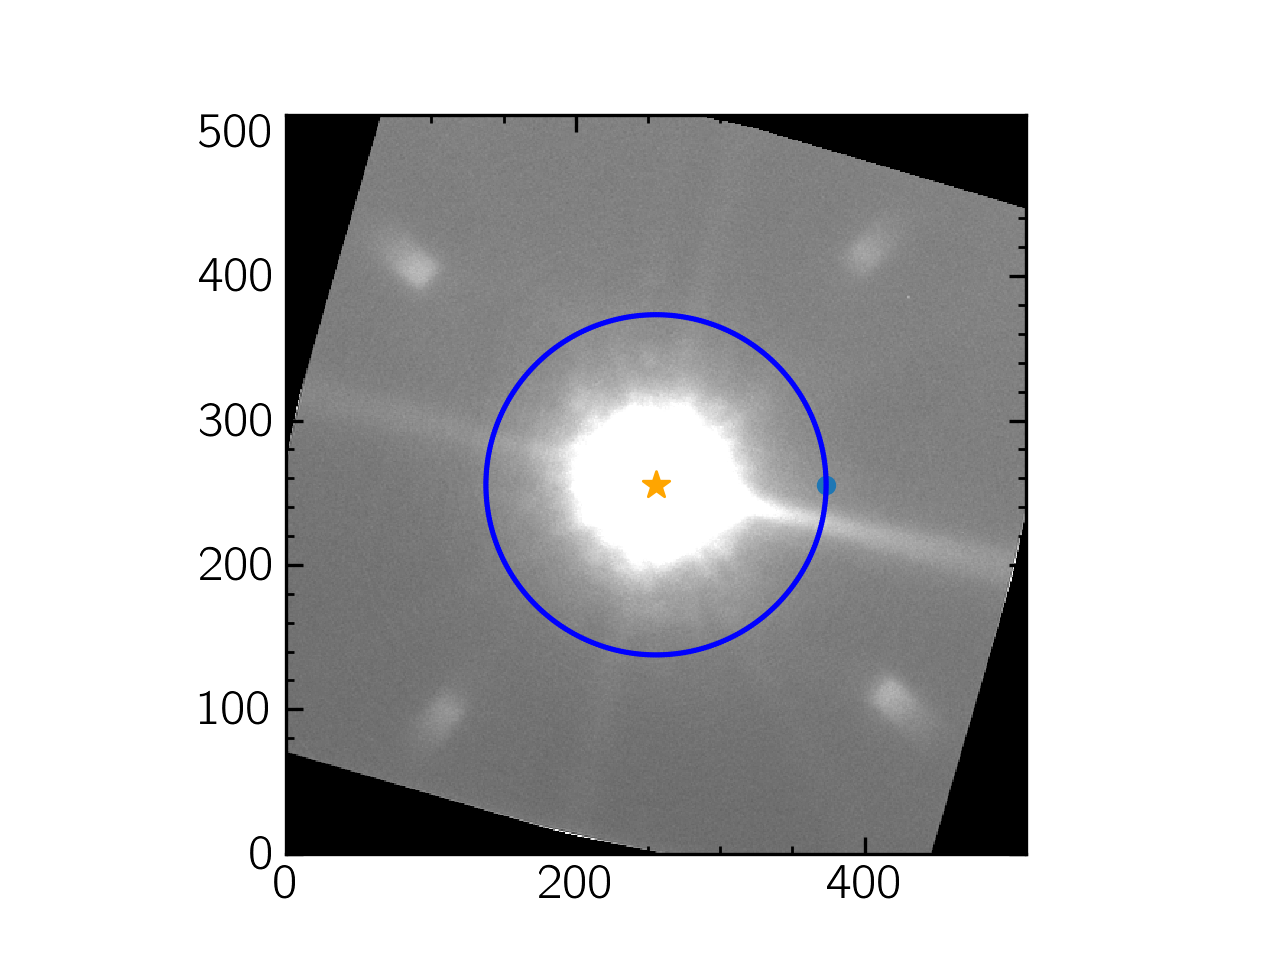

408.0
7769.477508965915
1821804.5
1821804.5


In [2]:
# Estimate bkgd noise:
from photutils import CircularAperture, CircularAnnulus, aperture_photometry
filters = {'z':0.908,'i':0.762,'r':0.615,'g':0.525}
sep = 65
pa = 270

radius = lod_to_pixels(1., filters[filt])/2
lod = 2*radius
xc,yc = (im.shape[0] - 1) * 0.5, (im.shape[1] - 1)*0.5
seppix = lod_to_pixels(sep, filters[filt])
xx = seppix*np.sin(np.radians((pa)))
yy = seppix*np.cos(np.radians((pa)))
xp,yp = xc-xx,yc+yy
aperture = CircularAperture([xp,yp], r=radius)

def lambdaoverD_to_arcsec(lamb, D = 6.5):
    """ Compute lamb/D.  Default is for Magellan mirror and CLIO narrow camera pixelscale.
        Inputs:
            lamb [um]: central wavelength of filter in microns.  Astropy unit object preferred
            D [m]: primary mirror diameter.  Astropy unit object required
            pixscale [mas/pix]: 
        Returns:
            loverd [arcsec]: lambda/D in arcsec per L/D
    """
    arcsec = (0.2063*(lamb/D))
    return arcsec

def lambdaoverD_pix(lamb, pixscale = 15.9, D = 6.5):
    import astropy.units as u
    loverd = lambdaoverD_to_arcsec(lamb, D = D)
    loverd_pix = loverd*u.arcsec.to(u.mas) / pixscale
    return loverd_pix

def lod_to_pixels(lod, lamb, pixscale = 15.9, D = 6.5):
    """ Convert separation in lambda/D to pixels
    """
    loverd_pix = lambdaoverD_pix(lamb, pixscale=pixscale, D = D)
    return lod*loverd_pix

fwhm = lod_to_pixels(1., filters[filt], pixscale = 6, D = 6.5)
print(fwhm,fwhm/2.35)

%matplotlib inline
plt.imshow(im, origin='lower', cmap='gray',\
           norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.scatter(xc,yc,marker="*",color='orange',s=100)
plt.scatter(xp,yp)
# Number of 1L/D apertures that can fit on the circumference at separation:
Napers = np.floor(sep*2*np.pi)
print(Napers)
# Change in angle from one aper to the next:
dTheta = 360/Napers

pas = np.arange(pa,pa+360,dTheta)%360    
for p in pas:
    xx = seppix*np.sin(np.radians((p)))
    yy = seppix*np.cos(np.radians((p)))
    xp,yp = xc-xx,yc+yy
    CircularAperture([xp,yp], r=radius).plot(color='blue')
    
    
noisesums = np.zeros(len(pas))

for i in range(len(pas)):
    xx = seppix*np.sin(np.radians((pas[i])))
    yy = seppix*np.cos(np.radians((pas[i])))
    xp,yp = xc-xx,yc+yy
    aperture = CircularAperture([xp,yp], r=radius)
    phot = aperture_photometry(im, aperture)
    noisesums[i] = phot['aperture_sum'][0]
noise = np.std(noisesums)
# T-test correction for small number statistics
noise = noise * np.sqrt(1+ (1/np.size(pas)))
print(noise)
#bkgd_initial_guess = np.median(noisesums)
bkgd_initial_guess = np.median(im[400:450,300:350])
print(bkgd_initial_guess)
print(np.median(im[400:450,300:350]))

<IPython.core.display.Javascript object>


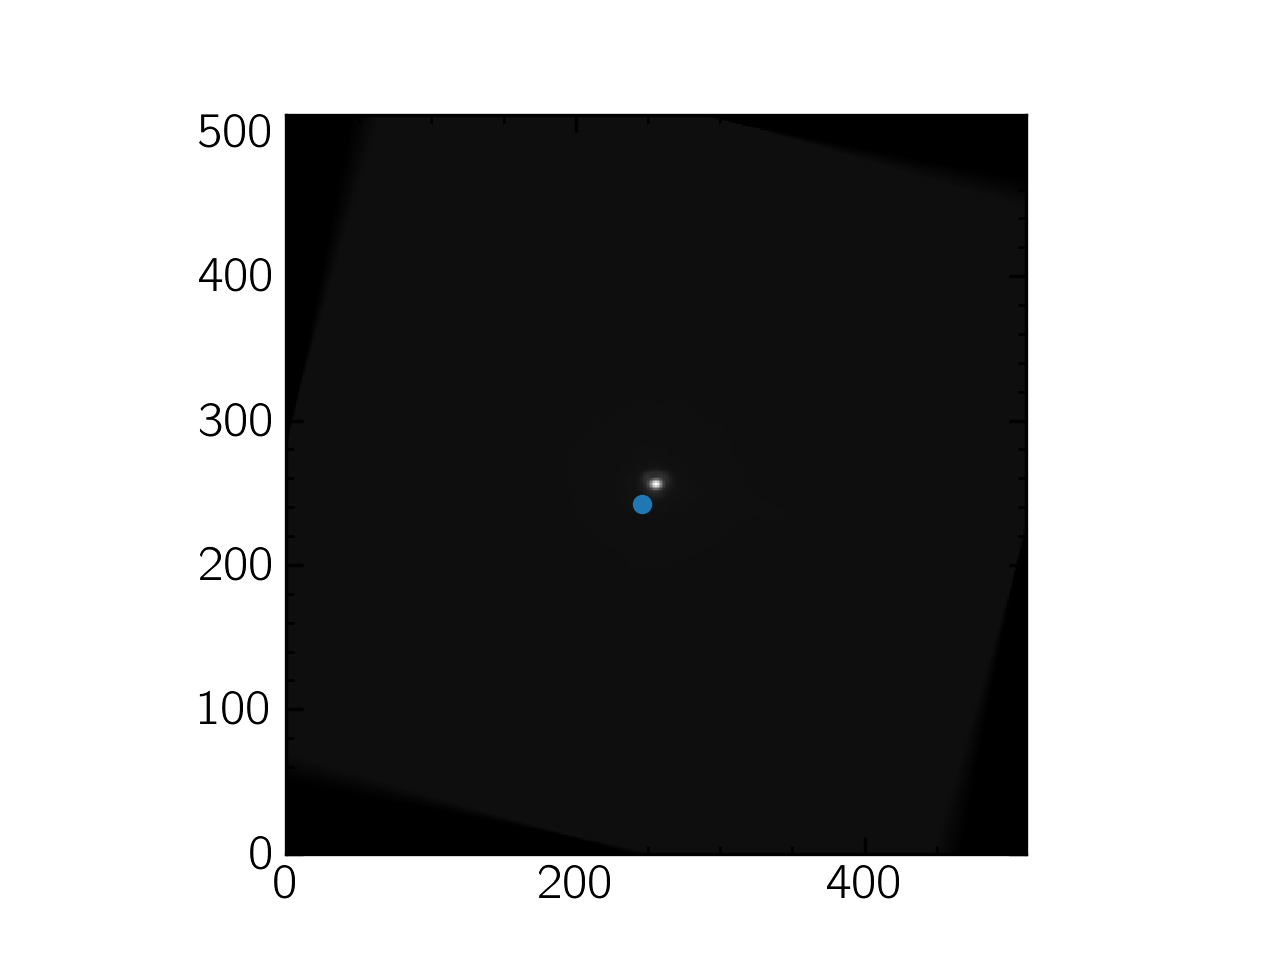

In [4]:
pois = np.sqrt(np.abs(im))

error_array = np.ones((im.shape))
error_array = error_array * noise

error_array = np.sqrt(error_array**2+pois**2)


In [5]:
amp_sigma = error_array[int(initial_guess[1]),int(initial_guess[0])]
amp_sigma = noise
initial_amp = im[int(initial_guess[1]),int(initial_guess[0])]
amp_sigma, initial_amp, bkgd_initial_guess

(7769.477508965915, 3538215.0, 1821804.5)

In [6]:
from astropy.modeling import models, fitting
from astropy.modeling.functional_models import Gaussian2D

# Define Prior functions:
def UniformPrior(x, xmin = -10., xmax = 10.):
    lnprob = 0. if xmin < x < xmax else -np.inf
    return lnprob

def SinPrior(x, interval = [0.,np.pi]):
    lnprob = np.log(np.sin(x))
    if (x < interval[0]) or (x > interval[1]):
        lnprob = -np.inf
    return lnprob

def LogUniformPrior(x, logmax=6, logmin=0):
    lnprob = -np.log((x))
    if (np.log(x) < logmin) or (np.log(x) > logmax):
        lnprob = -np.inf
    return lnprob

def GaussianPrior(x, mu = 0, sigma = 1):
    lnprob = -0.5*np.log(2.*np.pi*sigma) - 0.5*((x - mu) / sigma)**2
    return lnprob

def GaussianPrior2(x, mu = 0, sigma = 1, interval = [0.,np.pi]):
    lnprob = -0.5*np.log(2.*np.pi*sigma) - 0.5*((x - mu) / sigma)**2
    if (x < interval[0]) or (x > interval[1]):
        lnprob = -np.inf
    return lnprob

def GaussianPrior3(x, mu = 0, sigma = 1, interval = [0.,im.shape[0]]):
    lnprob = -0.5*np.log(2.*np.pi*sigma) - 0.5*((x - mu) / sigma)**2
    if (x < interval[0]) or (x > interval[1]):
        lnprob = -np.inf
    return lnprob

def GaussianPrior4(x, mu = 0, sigma = 1, interval = [amp_sigma-amp_sigma*30,amp_sigma+amp_sigma*30]):
    lnprob = -0.5*np.log(2.*np.pi*sigma) - 0.5*((x - mu) / sigma)**2
    if (x < interval[0]) or (x > interval[1]):
        lnprob = -np.inf
    return lnprob


# Establish the priors specific to our system:
def LogPriors(params):
    ''' Compute the prior probability of a proposed set of
        Keplerian orbit fitting parameters.
        Parameters:
        -----------
        params : 1d array
            xcs, ycs = x,y of Gaussian
            amps = amplitude
            bkgd = background level
            sigmax, sigmay = std dev in x,y axis
            theta = angle of rotation of x,y axis
        Returns:
        --------
        logprior : float
            log(prior probability) of proposed values for parameters
    '''
    logprior = 0.
    # xcs:
    logprior += GaussianPrior3(params[0], mu = initial_guess[0], sigma = 0.3)
    # ycs:
    logprior += GaussianPrior3(params[1], mu = initial_guess[1], sigma = 0.3)
    # amps:
    logprior += GaussianPrior(params[2], mu = params[2], sigma = amp_sigma)
    # bkgd:
    logprior += GaussianPrior(params[3], mu = bkgd_initial_guess, sigma = noise)
    # sigmax:
    logprior += GaussianPrior2(params[4], mu = params[4], sigma = 0.01)
    # sigmay:
    logprior += GaussianPrior2(params[5], mu = params[5], sigma = 0.01)
    # theta:
    logprior += UniformPrior(params[6], xmin = 0., xmax = np.pi/2)
    
    return logprior

def ComputeModel(params):
    xcs,ycs,amps,bkgd3,sigmax,sigmay,theta = params
    amps = amps-bkgd3
    psfs1 = models.Gaussian2D(amplitude = amps, x_mean=xcs, y_mean=ycs, 
                              x_stddev=fwhm/2.35, y_stddev=fwhm/2.35, theta=0)
    psfs = psfs1(x,y)
    bkgd = np.ndarray(shape=im.shape, dtype=float)
    bkgd.fill(bkgd3)
    psf = psfs + bkgd
    return psf
    
    
def LogLikelihood(params, data, error):
    ''' Compute the likelihood of the proposed model given observations
        Parameters:
        -----------
        params : 1d array
            proposed values for Keplerian orbital elements in order:
                sma [as] : semi-major axis in arcsec (as)
                ecc : eccentricity
                inc [rad] : inclination in radians
                argp [rad] : arguement of periastron in radians
                lon [rad] : longitude of nodes in radians
                tau : orbit phase, or fraction of orbit completed at reference date
                mass [Msun] : total system mass in solar masses
                distance [pc] : distance of system from Earth in parsecs
        data : 1d array
            observations in the following order:
                dRA [as] : relative separation of two bodies in RA direction in arcsec
                dDec [as] : rel separation in DEC direction in arcsec
                dpmRA [km/s] : rel difference in proper motion in RA in km/s
                dpmDec [km/s] : rel difference in proper motion in Dec
                dRV [km/s] : rel difference in radial velocity
                daccRA [m/s/yr] : rel difference in acceleration in RA in m/s/yr
                daccDec [m/s/yr] : rel difference in acceleration in Dec
        error : 1d array
            error in observations in the same order as data
            
        Returns:
        --------
        chi2lnlike : float
            log likelihood of model given observations
    '''
    # Compute model for proposed values:
    model = ComputeModel(params)
    residual = (data - model)
    chi2lnlike = -0.5 * np.sum(residual**2 / error**2 - np.log(np.sqrt(2*np.pi*(error**2))))
    return chi2lnlike

def LogProbability(params, data, error):
    ''' Compute the probability of the proposed model given observations
        Parameters:
        -----------
        params : 1d array
            values for 2d Gaussian model:
                xcs, ycs = x,y of Gaussian
                amps = amplitude
                bkgd = background level
                sigmax, sigmay = std dev in x,y axis
                theta = angle of rotation of x,y axis
        data : 2d array
            image
        error : 2d array
            error of same shape as image
            
        Returns:
        --------
        lnp + lnlike : float
            log probability of model given observations
    '''
    # Priors:
    lnp = LogPriors(params)
    # If any proposal is outside the parameter's range, computing the model
    # will fail and return a "nan", so if any prior returns -inf,
    # we skip the likelihood step and return -inf:
    if ~np.isfinite(lnp):
        return -np.inf
    # Else, compute likelihood of model given data:
    lnlike = LogLikelihood(params, data, error)
    return lnp + lnlike

(100, 7)


<IPython.core.display.Javascript object>


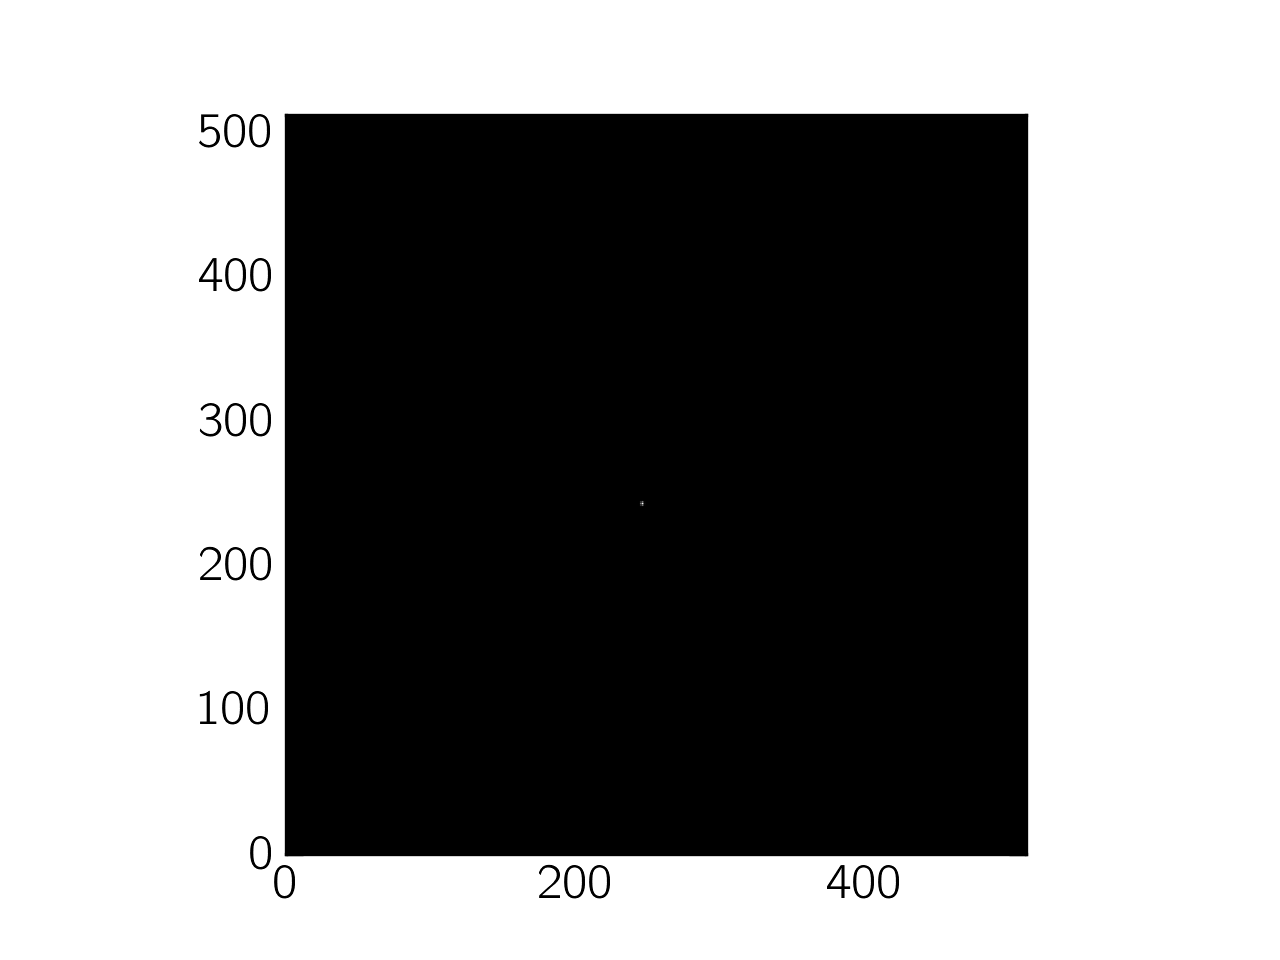

In [7]:
nwalkers = 100 # number of walkers
ndim = 7 # number of fit parameters
steps = 5000 # how many samples per chain

data = im
error = error_array

import emcee
sampler = emcee.EnsembleSampler(nwalkers,
                                ndim, 
                                LogProbability, # function for determining probability for a guess
                                args=(data, error) # args that go into likelihood function for testing the model
                               )

y, x = np.mgrid[:im.shape[0],:im.shape[1]]
initial_pos = np.array([initial_guess[0],initial_guess[1],initial_amp,bkgd_initial_guess, 
                        fwhm/2.35, fwhm/2.35, 0.])

pos = initial_pos + 1e-4 * np.random.randn(nwalkers, ndim)
pos[:,6] = 0.0001
print(pos.shape)

initial_model = ComputeModel(pos[0])
%matplotlib inline
plt.imshow(initial_model)

In [7]:
sampler.run_mcmc(pos, 5000, progress='notebook')

  0%|          | 0/5000 [00:00<?, ?it/s]

State([[ 2.55503259e+002  2.55506310e+002  6.74367040e+007  1.64496011e+006
   3.29813776e+122  9.66538254e+122  1.00000000e-004]
 [ 2.55503414e+002  2.55506117e+002  6.74326462e+007  1.64494445e+006
  -4.58036479e+122 -1.34230066e+123  1.00000000e-004]
 [ 2.55503379e+002  2.55505886e+002  6.74117752e+007  1.64497058e+006
  -9.58517663e+122 -2.80899154e+123  1.00000000e-004]
 [ 2.55503447e+002  2.55505633e+002  6.74293659e+007  1.64493782e+006
  -1.54564873e+122 -4.52959839e+122  1.00000000e-004]
 [ 2.55503293e+002  2.55505458e+002  6.74326284e+007  1.64495821e+006
   5.14268183e+122  1.50709096e+123  1.00000000e-004]
 [ 2.55503631e+002  2.55505608e+002  6.74305826e+007  1.64495260e+006
   1.94968025e+122  5.71365036e+122  1.00000000e-004]
 [ 2.55503594e+002  2.55506046e+002  6.74373916e+007  1.64496801e+006
   1.99668256e+122  5.85139978e+122  1.00000000e-004]
 [ 2.55503322e+002  2.55506121e+002  6.74301701e+007  1.64491694e+006
  -6.51662107e+122 -1.90972932e+123  1.00000000e-004]
 [

<IPython.core.display.Javascript object>


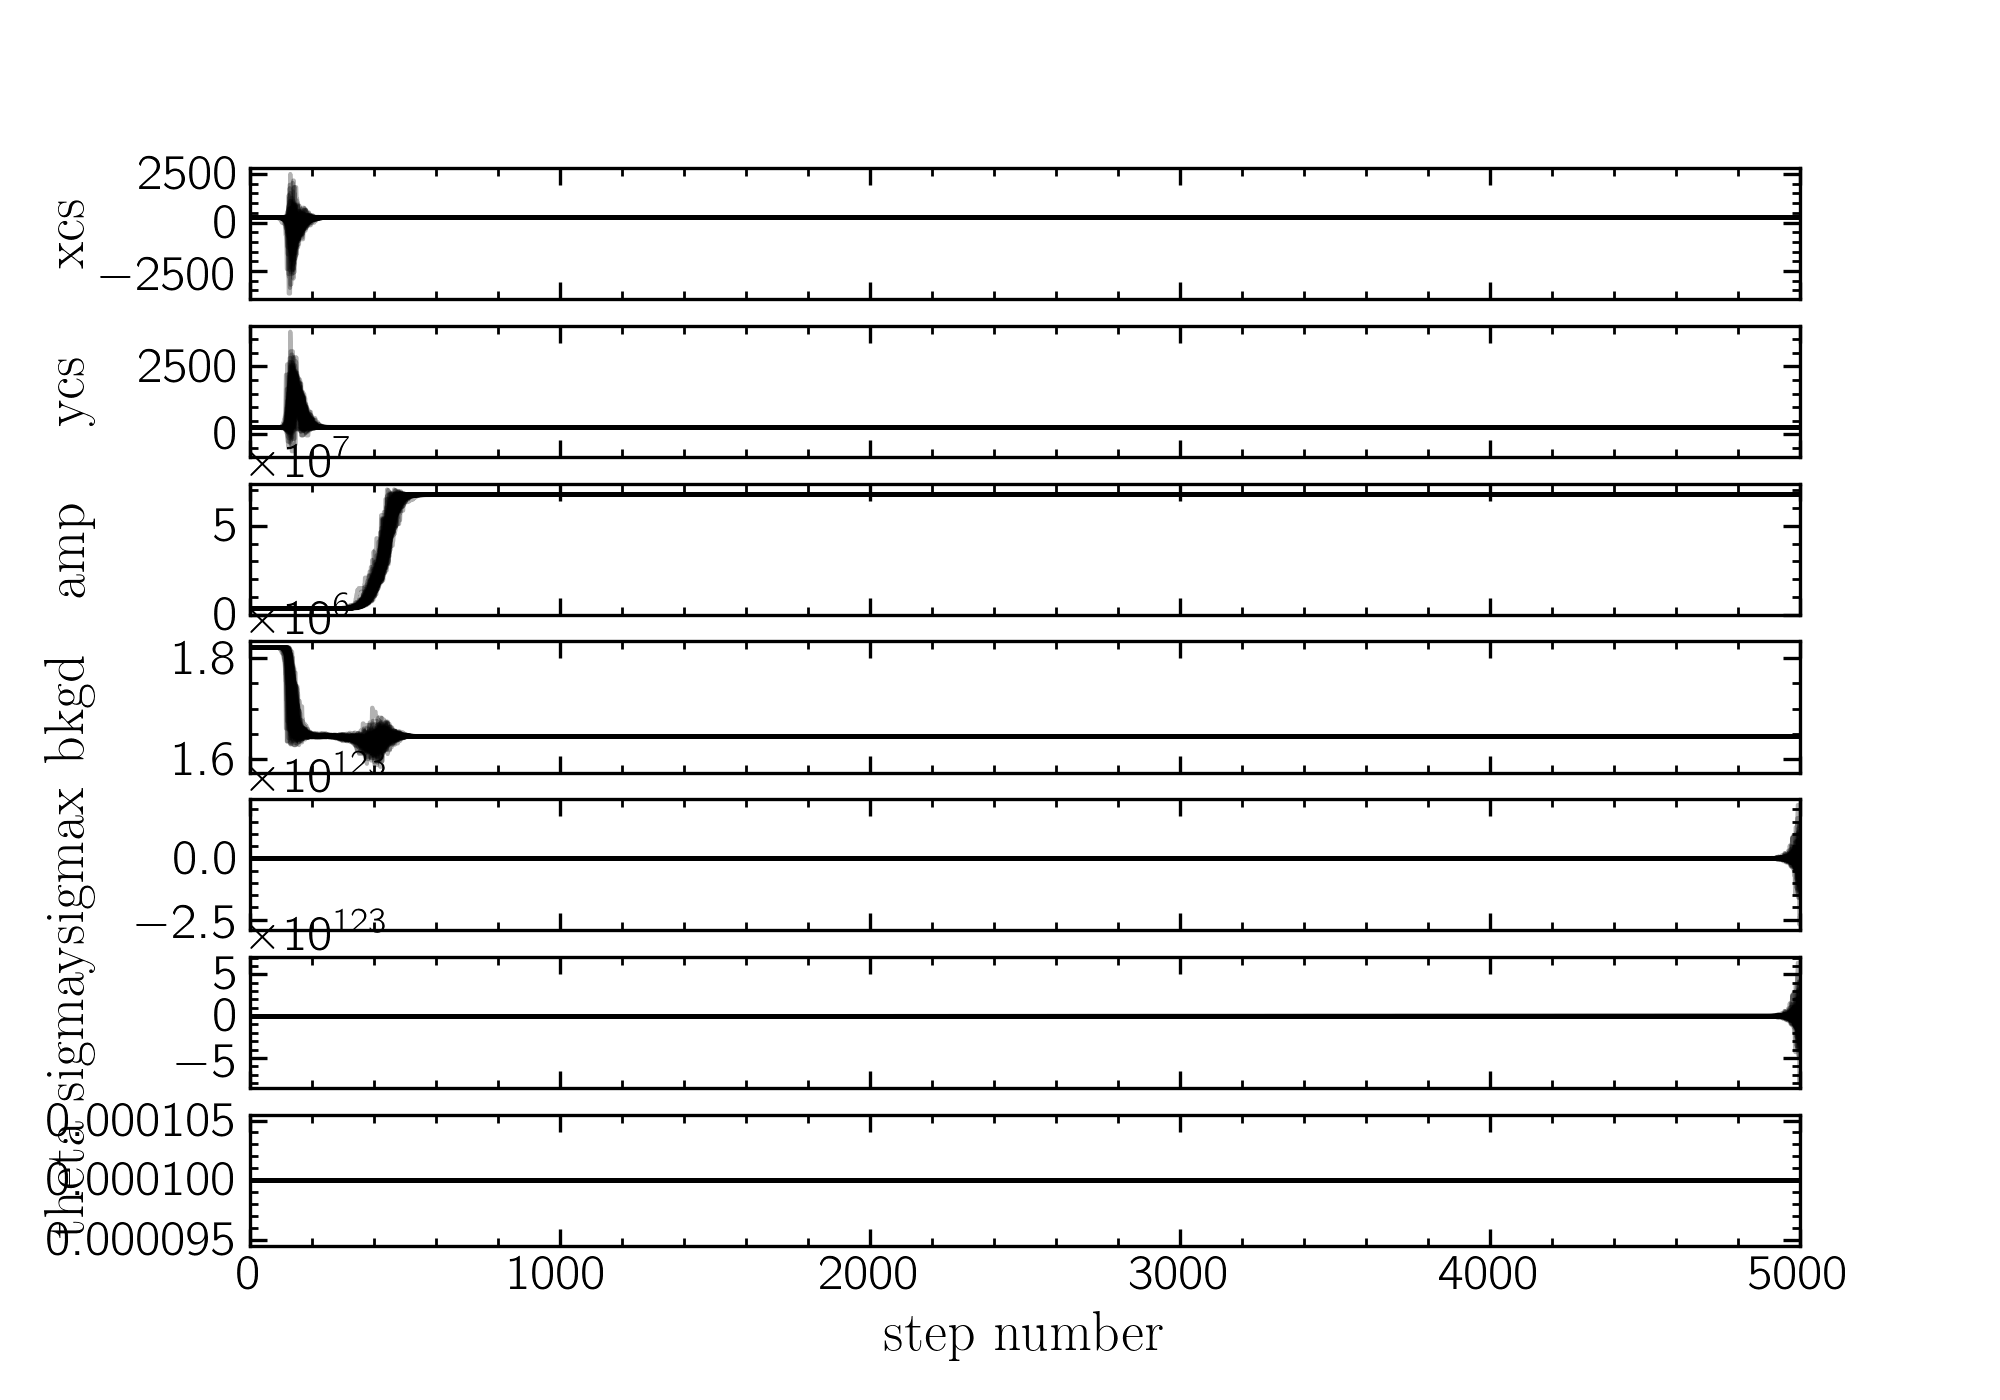

In [8]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["xcs", "ycs", "amp", 'bkgd', 'sigmax','sigmay','theta']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
os.system('say "done"')

<IPython.core.display.Javascript object>


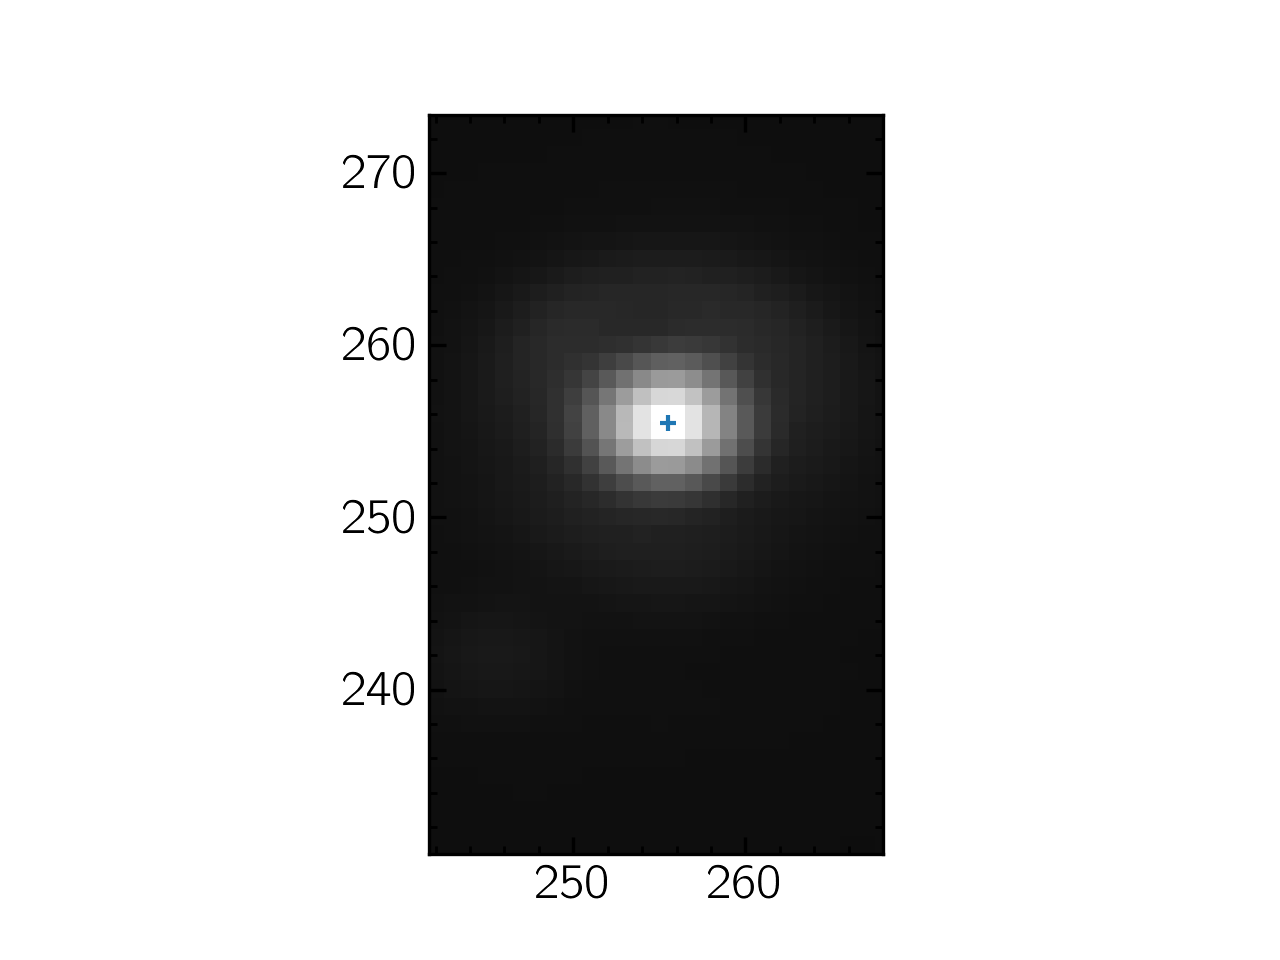

<ErrorbarContainer object of 3 artists>

In [9]:
xc, yc = np.mean(samples[1000:,:,0]),np.mean(samples[1000:,:,1])

%matplotlib inline
plt.imshow(im)
plt.scatter(xc,yc,marker='+')
plt.errorbar(xc,yc,xerr = np.std(samples[1000:,:,0]), yerr = np.std(samples[1000:,:,1]),ls='None')

In [12]:
import pickle
pickle.dump(samples,open('MagAOX_HIP67506Aposition_MCMC_chains.pkl','wb'))
np.std(samples[1000:,:,0]),np.std(samples[1000:,:,1])

(0.0003176317989512524, 0.0002855912247943432)

## C:

6871.5
5190.5


<IPython.core.display.Javascript object>


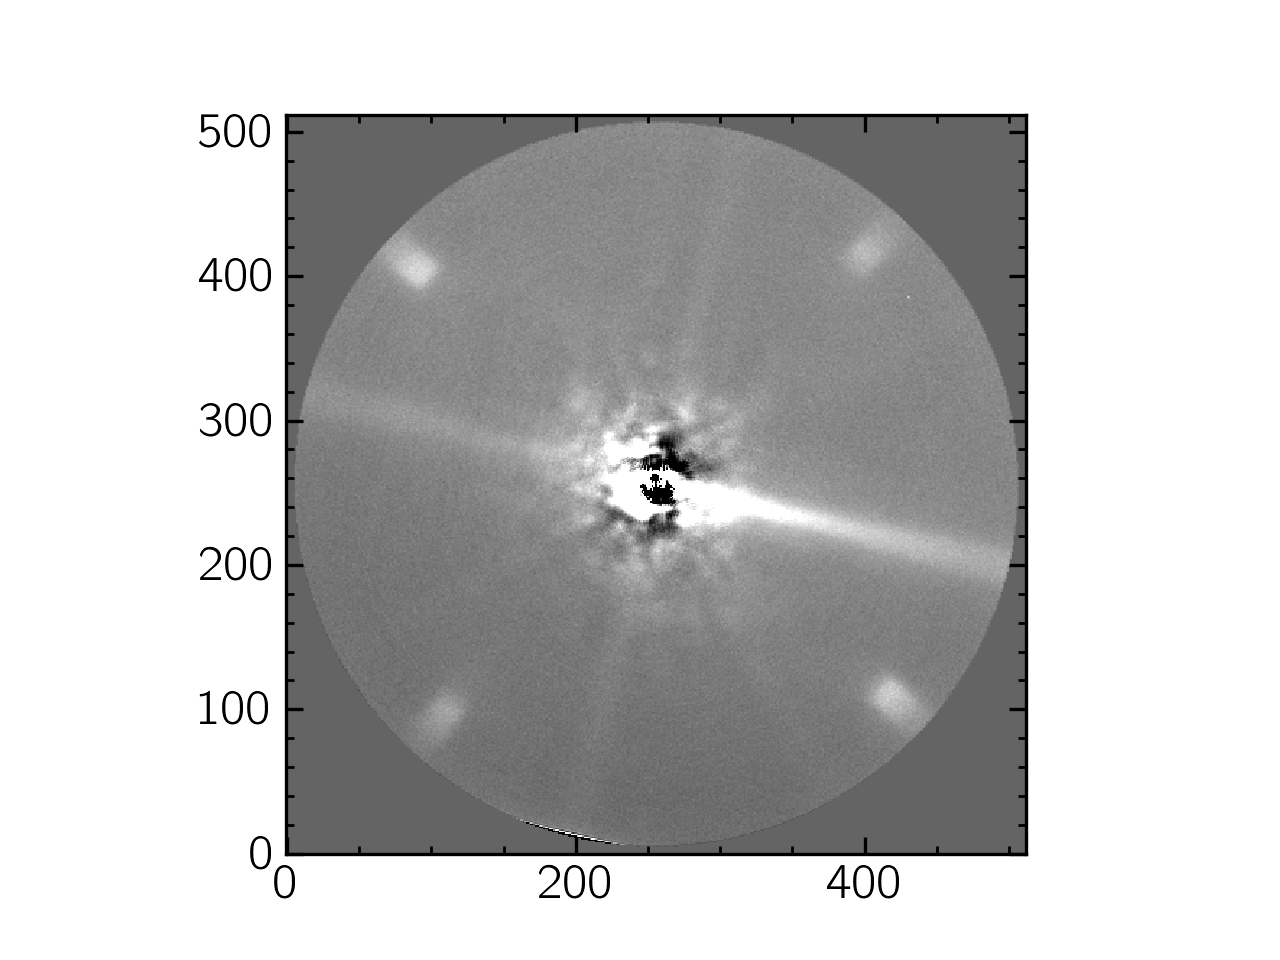

In [1]:
from astropy.modeling import models, fitting
from astropy.modeling.functional_models import Gaussian2D

# Open cube of rotated and registered images:
filt = 'z'
#imcube = fits.getdata(directory+sci+'_'+filt+'_stacked_shifted_rotated.fits')
im = fits.getdata('magaox_'+filt+'_stacked_shifted_rotated_radsubbed_summed.fits')

bkgd_initial_guess = np.median(im[400:450,300:350])
print(bkgd_initial_guess)
print(np.median(im))

%matplotlib inline
plt.imshow(im, origin='lower', cmap='gray',\
           norm = ImageNormalize(im, interval=ZScaleInterval(),))

1.8124857281083697 0.7712705225993063


<IPython.core.display.Javascript object>


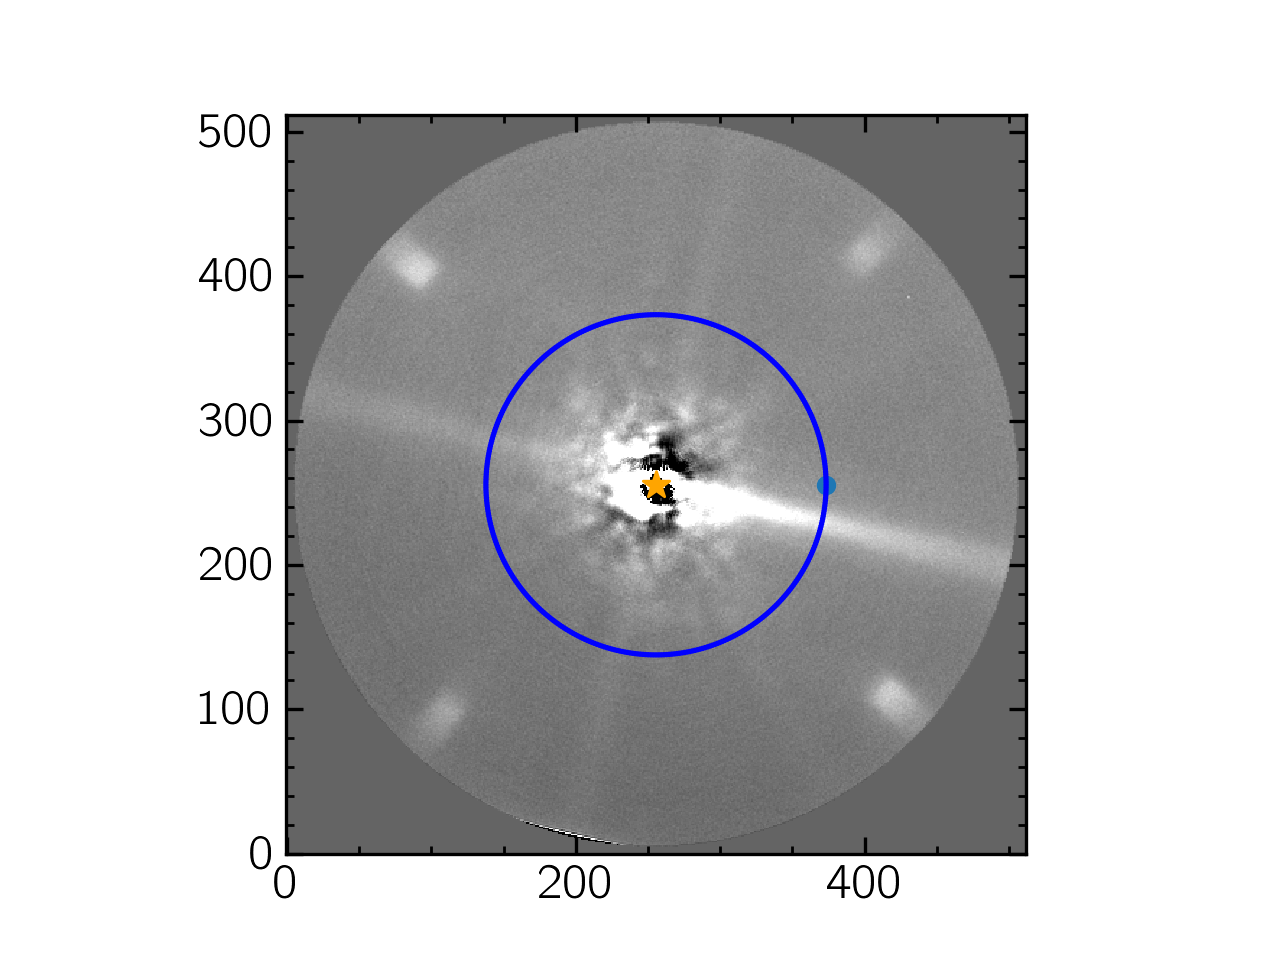

408.0
7770.208417848874
6871.5
6871.5


In [2]:
#
from photutils import CircularAperture, CircularAnnulus, aperture_photometry
filters = {'z':0.908,'i':0.762,'r':0.615,'g':0.525}
sep = 65
pa = 270

radius = lod_to_pixels(1., filters[filt])/2
lod = 2*radius
xc,yc = (im.shape[0] - 1) * 0.5, (im.shape[1] - 1)*0.5
seppix = lod_to_pixels(sep, filters[filt])
xx = seppix*np.sin(np.radians((pa)))
yy = seppix*np.cos(np.radians((pa)))
xp,yp = xc-xx,yc+yy
aperture = CircularAperture([xp,yp], r=radius)

fwhm = lod_to_pixels(1., filters[filt])


%matplotlib inline
plt.imshow(im, origin='lower', cmap='gray',\
           norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.scatter(xc,yc,marker="*",color='orange',s=100)
plt.scatter(xp,yp)
# Number of 1L/D apertures that can fit on the circumference at separation:
Napers = np.floor(sep*2*np.pi)
print(Napers)
# Change in angle from one aper to the next:
dTheta = 360/Napers

pas = np.arange(pa,pa+360,dTheta)%360    
for p in pas:
    xx = seppix*np.sin(np.radians((p)))
    yy = seppix*np.cos(np.radians((p)))
    xp,yp = xc-xx,yc+yy
    CircularAperture([xp,yp], r=radius).plot(color='blue')
    
    
noisesums = np.zeros(len(pas))

for i in range(len(pas)):
    xx = seppix*np.sin(np.radians((pas[i])))
    yy = seppix*np.cos(np.radians((pas[i])))
    xp,yp = xc-xx,yc+yy
    aperture = CircularAperture([xp,yp], r=radius)
    phot = aperture_photometry(im, aperture)
    noisesums[i] = phot['aperture_sum'][0]
noise = np.std(noisesums)
# T-test correction for small number statistics
noise = noise * np.sqrt(1+ (1/np.size(pas)))
print(noise)
#bkgd_initial_guess = np.median(noisesums)
bkgd_initial_guess = np.median(im[400:450,300:350])
print(bkgd_initial_guess)
print(np.median(im[400:450,300:350]))

In [3]:
from myastrotools.tools import CenteredDistanceMatrix
rrr = CenteredDistanceMatrix(im.shape[0])

im_masked = im.copy()
im_masked = im_masked - bkgd_initial_guess
bkgd_initial_guess = np.median(im_masked[400:450,300:350])
im_masked[np.where(rrr < 13)] = 0



In [4]:
pois = np.sqrt(np.abs(im_masked))

error_array = np.ones((im.shape))
error_array = error_array * noise

error_array = np.sqrt(error_array**2+pois**2)

In [5]:
initial_guess = np.array([246.375 - 1, 242.818 - 1])

amp_sigma = error_array[int(initial_guess[1]),int(initial_guess[0])]
amp_sigma = noise
initial_amp = im[int(initial_guess[1]),int(initial_guess[0])]
amp_sigma, initial_amp, bkgd_initial_guess

(7770.208417848874, 1311964.5, 0.0)

1305093.0 7853.739991673362
7770.208417848874 233106.25253546622


<IPython.core.display.Javascript object>


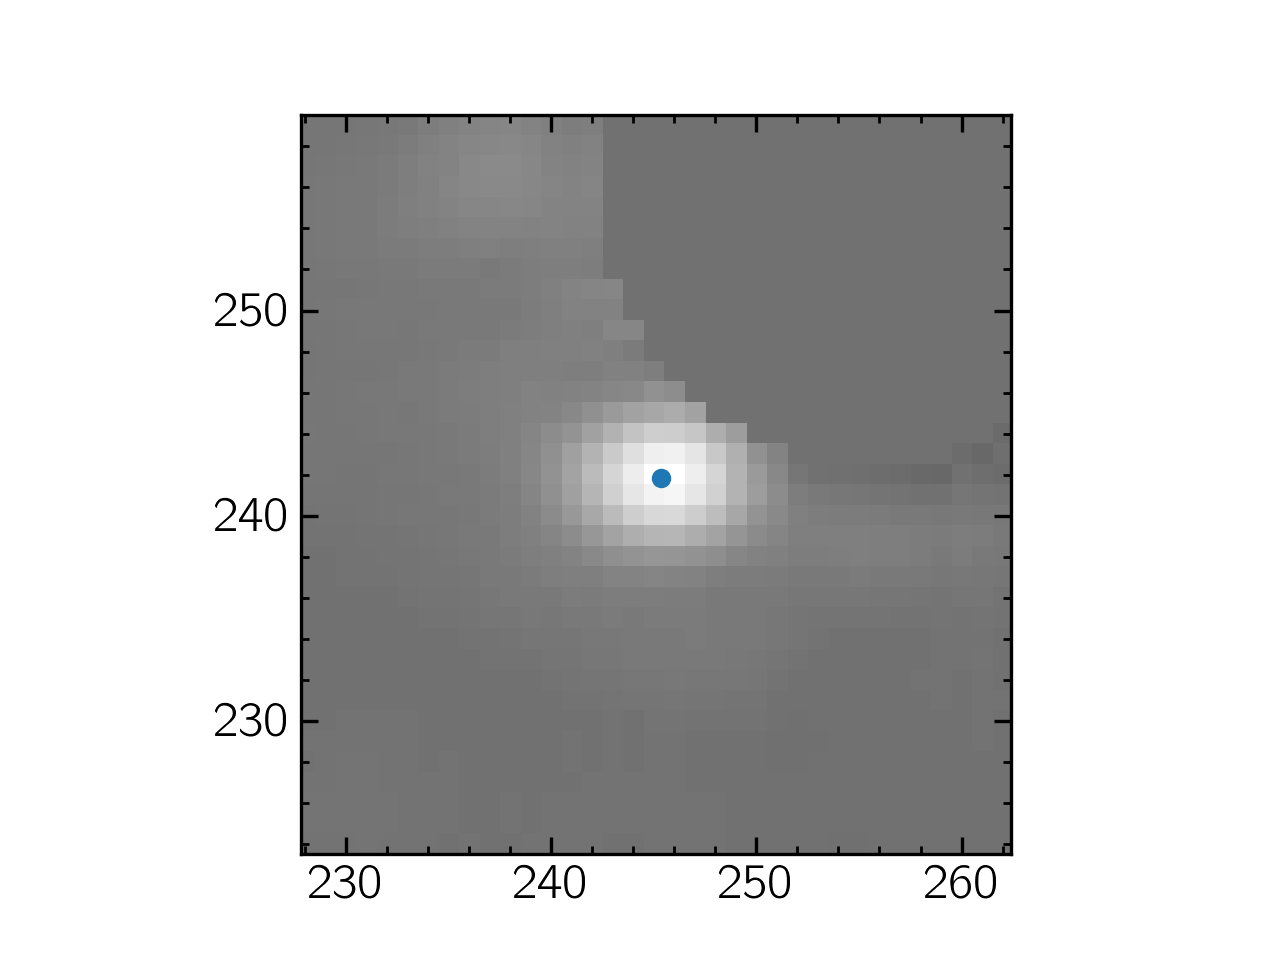

1311964.5 245 241


In [6]:
initial_amp = im_masked[int(initial_guess[1]),int(initial_guess[0])]

%matplotlib inline
plt.imshow(im_masked)
plt.scatter(*initial_guess)
print(im[int(initial_guess[1]),int(initial_guess[0])], int(initial_guess[0]),int(initial_guess[1]))

In [7]:
from astropy.modeling import models, fitting
from astropy.modeling.functional_models import Gaussian2D
y, x = np.mgrid[:im.shape[0],:im.shape[1]]

# Define Prior functions:
def UniformPrior(x, xmin = -10., xmax = 10.):
    lnprob = 0. if xmin < x < xmax else -np.inf
    return lnprob

def SinPrior(x, interval = [0.,np.pi]):
    lnprob = np.log(np.sin(x))
    if (x < interval[0]) or (x > interval[1]):
        lnprob = -np.inf
    return lnprob

def LogUniformPrior(x, logmax=6, logmin=0):
    lnprob = -np.log((x))
    if (np.log(x) < logmin) or (np.log(x) > logmax):
        lnprob = -np.inf
    return lnprob

def GaussianPrior(x, mu = 0, sigma = 1):
    lnprob = -0.5*np.log(2.*np.pi*sigma) - 0.5*((x - mu) / sigma)**2
    return lnprob

def GaussianPrior2(x, mu = 0, sigma = 1, interval = [0.,np.pi/4]):
    lnprob = -0.5*np.log(2.*np.pi*sigma) - 0.5*((x - mu) / sigma)**2
    if (x < interval[0]) or (x > interval[1]):
        lnprob = -np.inf
    return lnprob

def GaussianPrior3(x, mu = 0, sigma = 1, interval = [0.,im.shape[0]]):
    lnprob = -0.5*np.log(2.*np.pi*sigma) - 0.5*((x - mu) / sigma)**2
    if (x < interval[0]) or (x > interval[1]):
        lnprob = -np.inf
    return lnprob

def GaussianPrior4(x, mu = 0, sigma = 1, interval = [amp_sigma-amp_sigma*30,amp_sigma+amp_sigma*30]):
    lnprob = -0.5*np.log(2.*np.pi*sigma) - 0.5*((x - mu) / sigma)**2
    if (x < interval[0]) or (x > interval[1]):
        lnprob = -np.inf
    return lnprob


# Establish the priors specific to our system:
def LogPriors(params):
    ''' Compute the prior probability of a proposed set of
        Keplerian orbit fitting parameters.
        Parameters:
        -----------
        params : 1d array
            xcs, ycs = x,y of Gaussian
            amps = amplitude
            bkgd = background level
            sigmax, sigmay = std dev in x,y axis
            theta = angle of rotation of x,y axis
        Returns:
        --------
        logprior : float
            log(prior probability) of proposed values for parameters
    '''
    logprior = 0.
    # xcs:
    logprior += GaussianPrior3(params[0], mu = initial_guess[0], sigma = fwhm/2.35)
    # ycs:
    logprior += GaussianPrior3(params[1], mu = initial_guess[1], sigma = fwhm/2.35)
    # amps:
    logprior += GaussianPrior(params[2], mu = params[2], sigma = amp_sigma)
    # bkgd:
    logprior += GaussianPrior(params[3], mu = bkgd_initial_guess, sigma = noise)
    # sigmax:
    logprior += GaussianPrior(params[4], mu = params[4], sigma = 0.01)
    # sigmay:
    logprior += GaussianPrior(params[5], mu = params[5], sigma = 0.01)
    # theta:
    logprior += UniformPrior(params[6], xmin = 0., xmax = np.pi/2)
    
    return logprior

def ComputeModel(params):
    xcs,ycs,amps,bkgd3,sigmax,sigmay,theta = params
    amps = amps-bkgd3
    psfs1 = models.Gaussian2D(amplitude = amps, x_mean=xcs, y_mean=ycs, 
                              x_stddev=sigmax, y_stddev=sigmay, theta=theta)
    psfs = psfs1(x,y)
    bkgd = np.ndarray(shape=im.shape, dtype=float)
    bkgd.fill(bkgd3)
    psf = psfs + bkgd
    return psf
    
    
def LogLikelihood(params, data, error):
    ''' Compute the likelihood of the proposed model given observations
        Parameters:
        -----------
        params : 1d array
            proposed values for Keplerian orbital elements in order:
                sma [as] : semi-major axis in arcsec (as)
                ecc : eccentricity
                inc [rad] : inclination in radians
                argp [rad] : arguement of periastron in radians
                lon [rad] : longitude of nodes in radians
                tau : orbit phase, or fraction of orbit completed at reference date
                mass [Msun] : total system mass in solar masses
                distance [pc] : distance of system from Earth in parsecs
        data : 1d array
            observations in the following order:
                dRA [as] : relative separation of two bodies in RA direction in arcsec
                dDec [as] : rel separation in DEC direction in arcsec
                dpmRA [km/s] : rel difference in proper motion in RA in km/s
                dpmDec [km/s] : rel difference in proper motion in Dec
                dRV [km/s] : rel difference in radial velocity
                daccRA [m/s/yr] : rel difference in acceleration in RA in m/s/yr
                daccDec [m/s/yr] : rel difference in acceleration in Dec
        error : 1d array
            error in observations in the same order as data
            
        Returns:
        --------
        chi2lnlike : float
            log likelihood of model given observations
    '''
    # Compute model for proposed values:
    model = ComputeModel(params)
    residual = (data - model)
    chi2lnlike = -0.5 * np.sum(residual**2 / error**2 - np.log(np.sqrt(2*np.pi*(error**2))))
    return chi2lnlike

def LogProbability(params, data, error):
    ''' Compute the probability of the proposed model given observations
        Parameters:
        -----------
        params : 1d array
            values for 2d Gaussian model:
                xcs, ycs = x,y of Gaussian
                amps = amplitude
                bkgd = background level
                sigmax, sigmay = std dev in x,y axis
                theta = angle of rotation of x,y axis
        data : 2d array
            image
        error : 2d array
            error of same shape as image
            
        Returns:
        --------
        lnp + lnlike : float
            log probability of model given observations
    '''
    # Priors:
    lnp = LogPriors(params)
    # If any proposal is outside the parameter's range, computing the model
    # will fail and return a "nan", so if any prior returns -inf,
    # we skip the likelihood step and return -inf:
    if ~np.isfinite(lnp):
        return -np.inf
    # Else, compute likelihood of model given data:
    lnlike = LogLikelihood(params, data, error)
    return lnp + lnlike

(100, 7) 1.8124857281083697


<IPython.core.display.Javascript object>


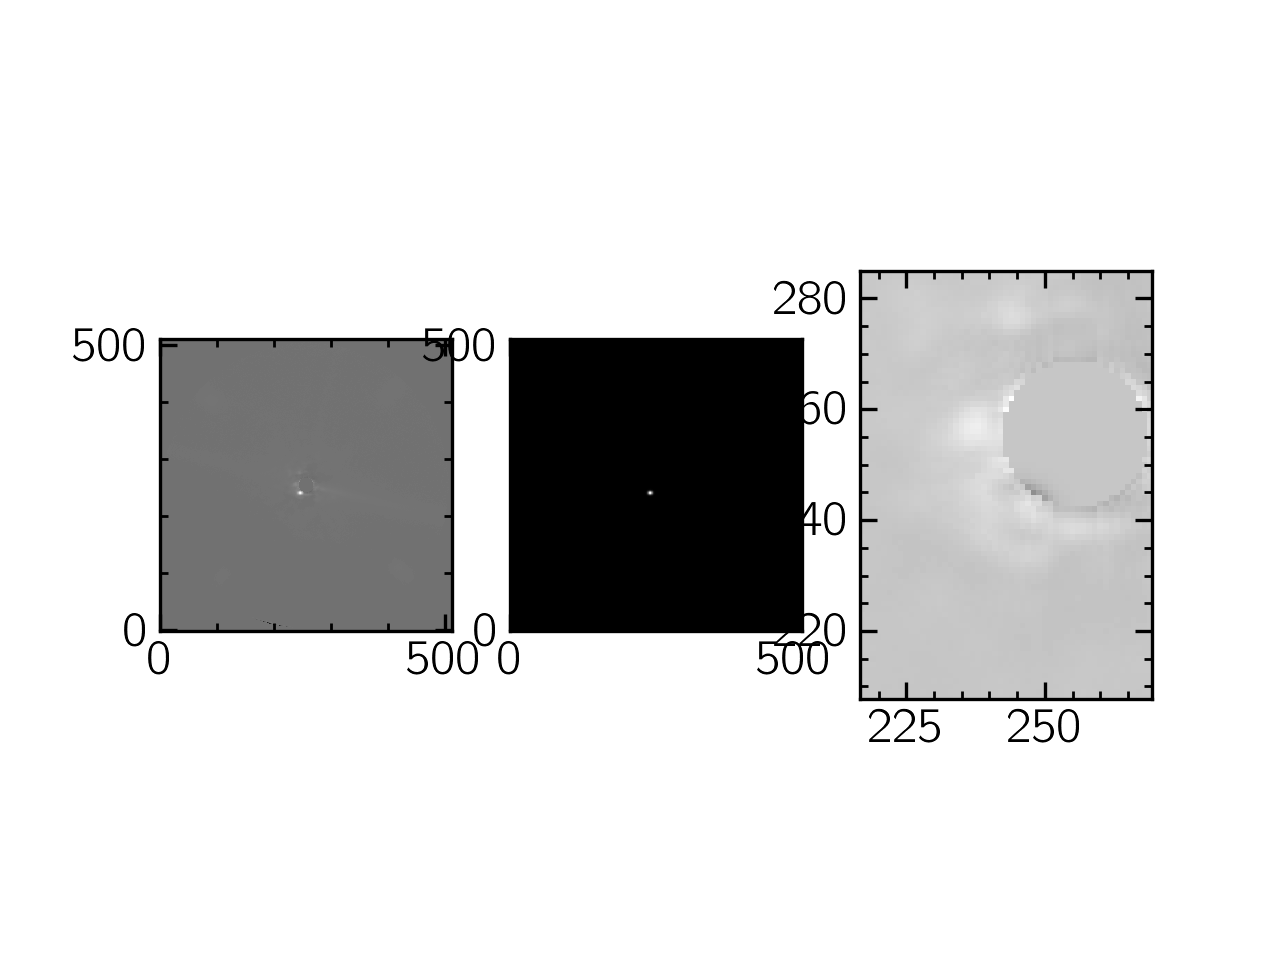

In [8]:
nwalkers = 100 # number of walkers
ndim = 7 # number of fit parameters
steps = 1000 # how many samples per chain

data = im_masked
error = error_array/2

import emcee
sampler = emcee.EnsembleSampler(nwalkers,
                                ndim, 
                                LogProbability, # function for determining probability for a guess
                                args=(data, error) # args that go into likelihood function for testing the model
                               )

y, x = np.mgrid[:im.shape[0],:im.shape[1]]
initial_pos = np.array([initial_guess[0],initial_guess[1],initial_amp,bkgd_initial_guess, 
                        fwhm+1, fwhm+0.5, 0.])

pos = initial_pos + 1e-4 * np.random.randn(nwalkers, ndim)
pos[:,6] = 0.0001
print(pos.shape,fwhm)

initial_model = ComputeModel(pos[0])
%matplotlib notebook
plt.subplot(131)
plt.imshow(im_masked)
plt.subplot(132)
plt.imshow(initial_model)
plt.subplot(133)
plt.imshow(im_masked - initial_model)

In [9]:
sampler.run_mcmc(pos, 5000, progress='notebook')

  0%|          | 0/5000 [00:00<?, ?it/s]

State([[ 2.45291467e+02  2.41729263e+02  1.40107211e+06 -1.57331258e+03
   3.06873125e+00  2.32825103e+00  1.00000000e-04]
 [ 2.45291872e+02  2.41728312e+02  1.40383332e+06 -1.56985853e+03
   3.07057921e+00  2.32350971e+00  1.00000000e-04]
 [ 2.45288961e+02  2.41728409e+02  1.40292828e+06 -1.57808841e+03
   3.06807766e+00  2.32438865e+00  1.00000000e-04]
 [ 2.45290585e+02  2.41725032e+02  1.40220592e+06 -1.56328171e+03
   3.07166170e+00  2.32735856e+00  1.00000000e-04]
 [ 2.45287807e+02  2.41724710e+02  1.40148898e+06 -1.56028754e+03
   3.07535740e+00  2.32800534e+00  1.00000000e-04]
 [ 2.45292308e+02  2.41728091e+02  1.40570935e+06 -1.55835157e+03
   3.06772235e+00  2.32330997e+00  1.00000000e-04]
 [ 2.45287082e+02  2.41728848e+02  1.40095361e+06 -1.56633778e+03
   3.07081841e+00  2.32680067e+00  1.00000000e-04]
 [ 2.45289059e+02  2.41726916e+02  1.40252951e+06 -1.57899885e+03
   3.07231453e+00  2.32925636e+00  1.00000000e-04]
 [ 2.45290652e+02  2.41727971e+02  1.40093893e+06 -1.56125

<IPython.core.display.Javascript object>


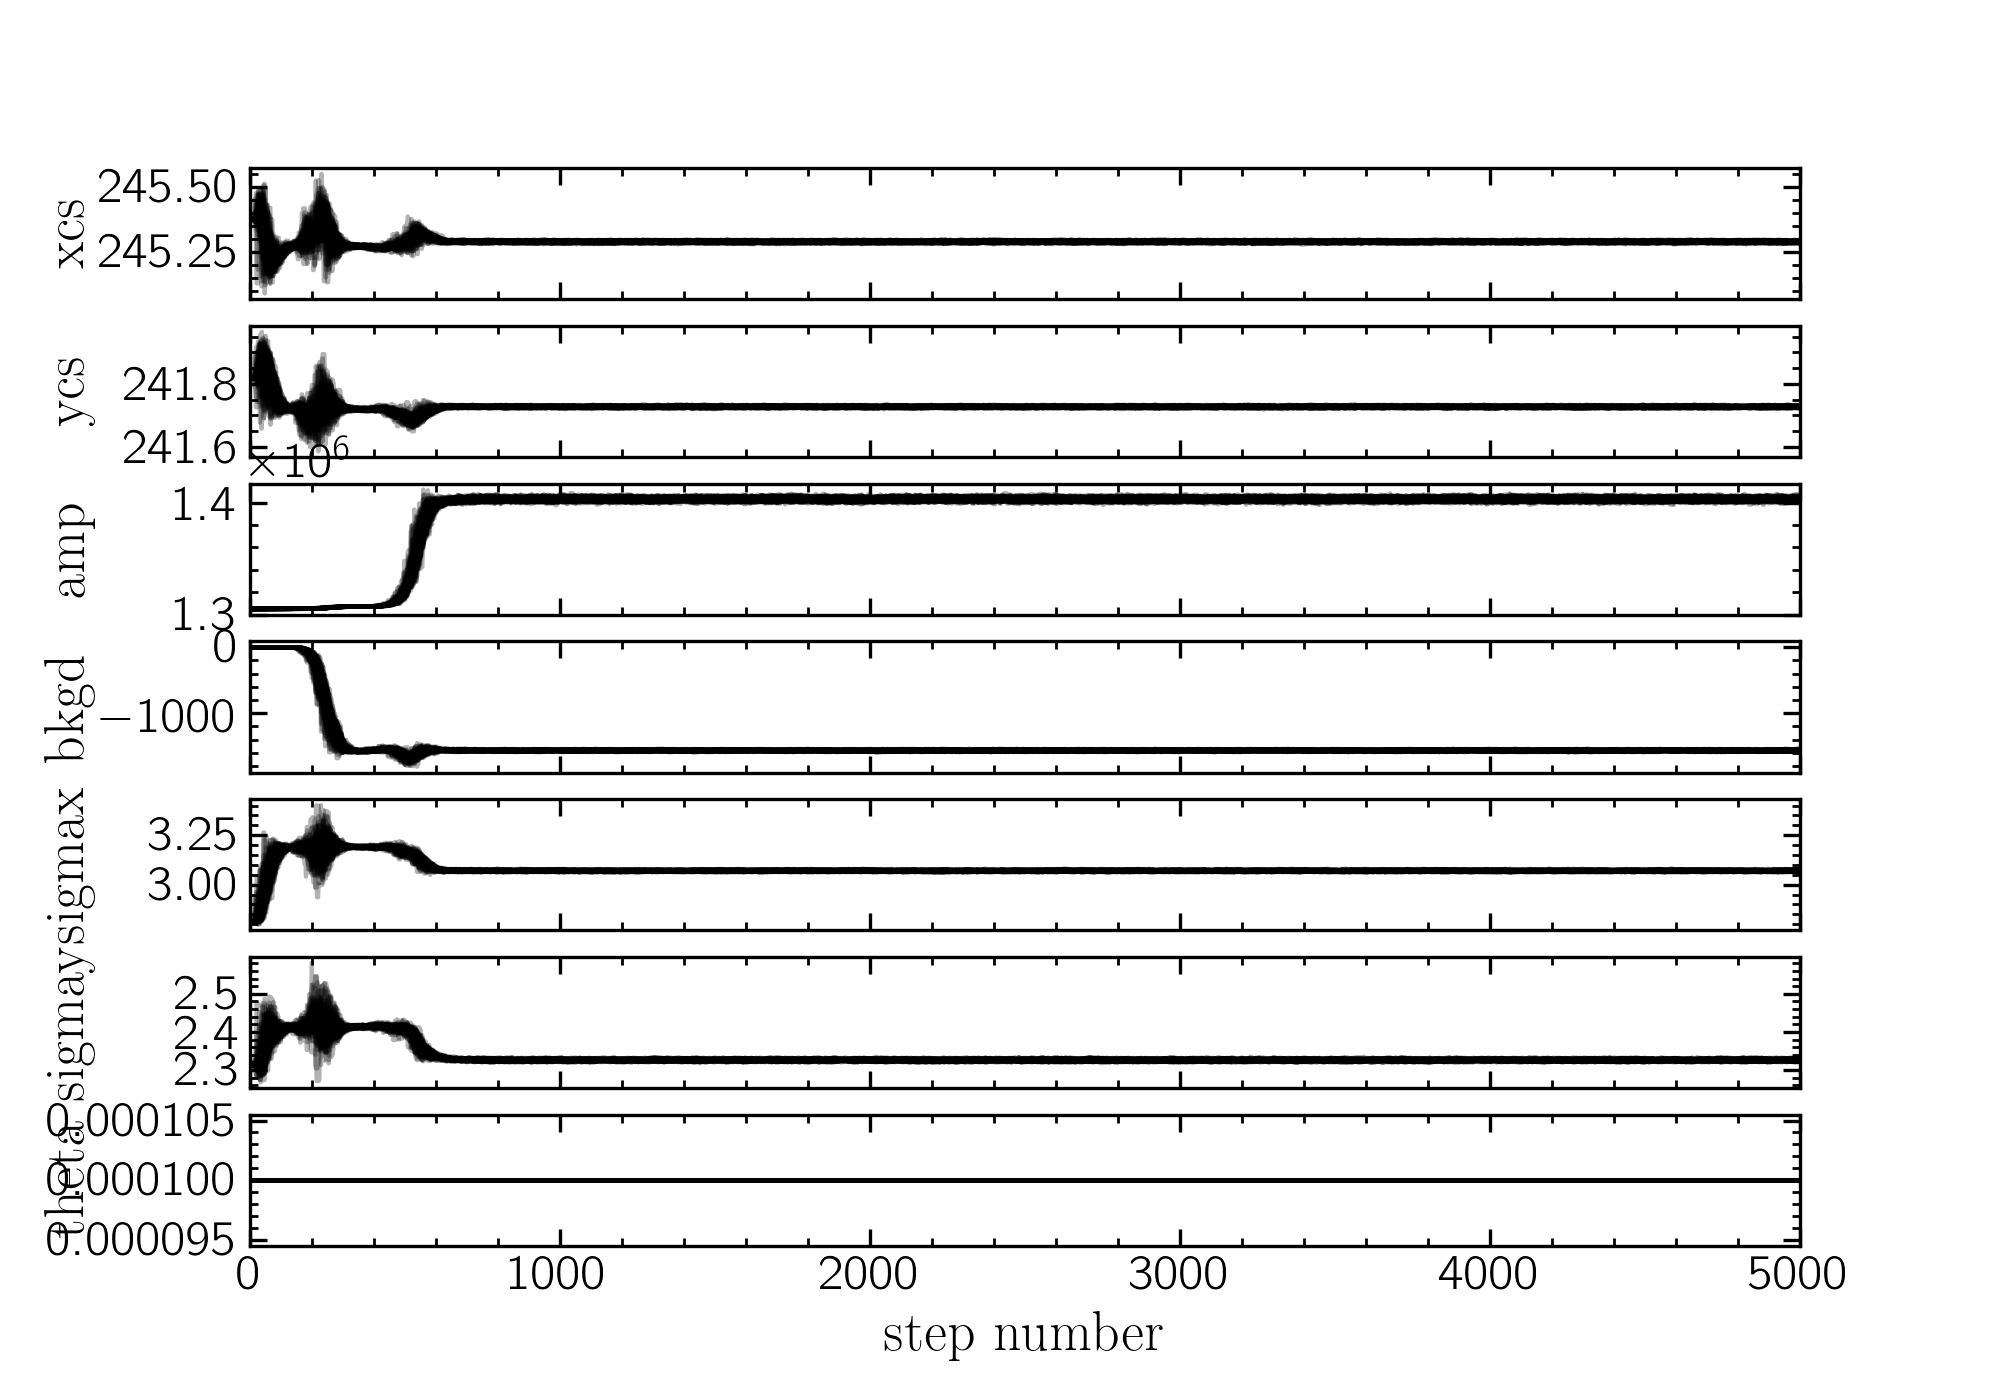

In [10]:
os.system('say "done"')

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
pickle.dump(samples,open('MagAOX_companionposition_MCMC_chains_5000steps.pkl','wb'))
labels = ["xcs", "ycs", "amp", 'bkgd', 'sigmax','sigmay','theta']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

<IPython.core.display.Javascript object>


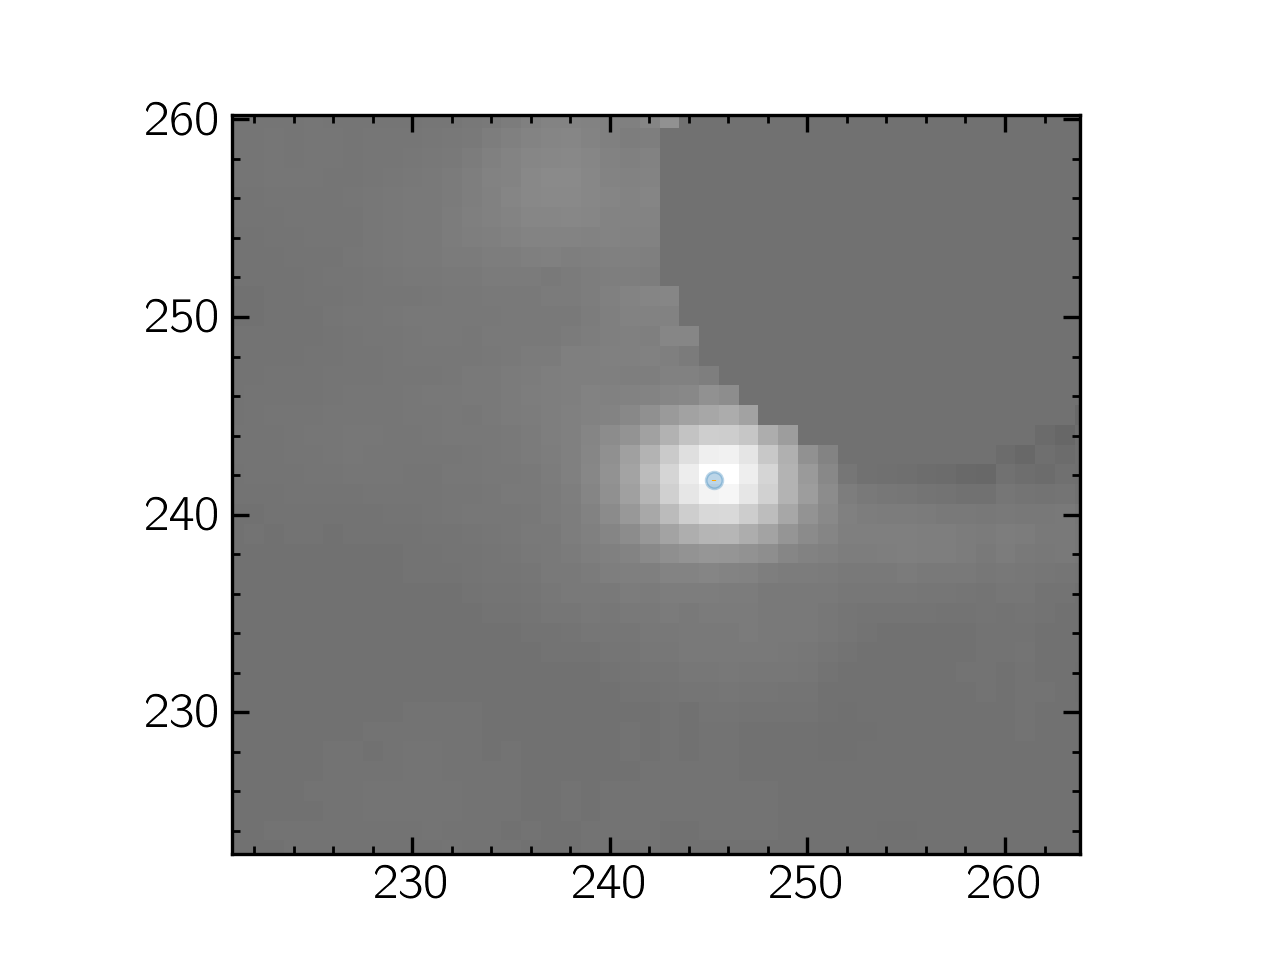

<ErrorbarContainer object of 3 artists>

In [12]:
xc, yc = np.mean(samples[1000:,:,0]),np.mean(samples[1000:,:,1])

%matplotlib inline
plt.imshow(im_masked)
plt.scatter(xc,yc,marker='o',alpha=0.3)
plt.errorbar(xc,yc,xerr = np.std(samples[1000:,:,0]), yerr = np.std(samples[1000:,:,1]),ls='None',color='orange')

In [15]:
np.std(samples[:,:,0]),np.std(samples[:,:,1])

(0.016330556732357997, 0.015980848881351824)

<IPython.core.display.Javascript object>


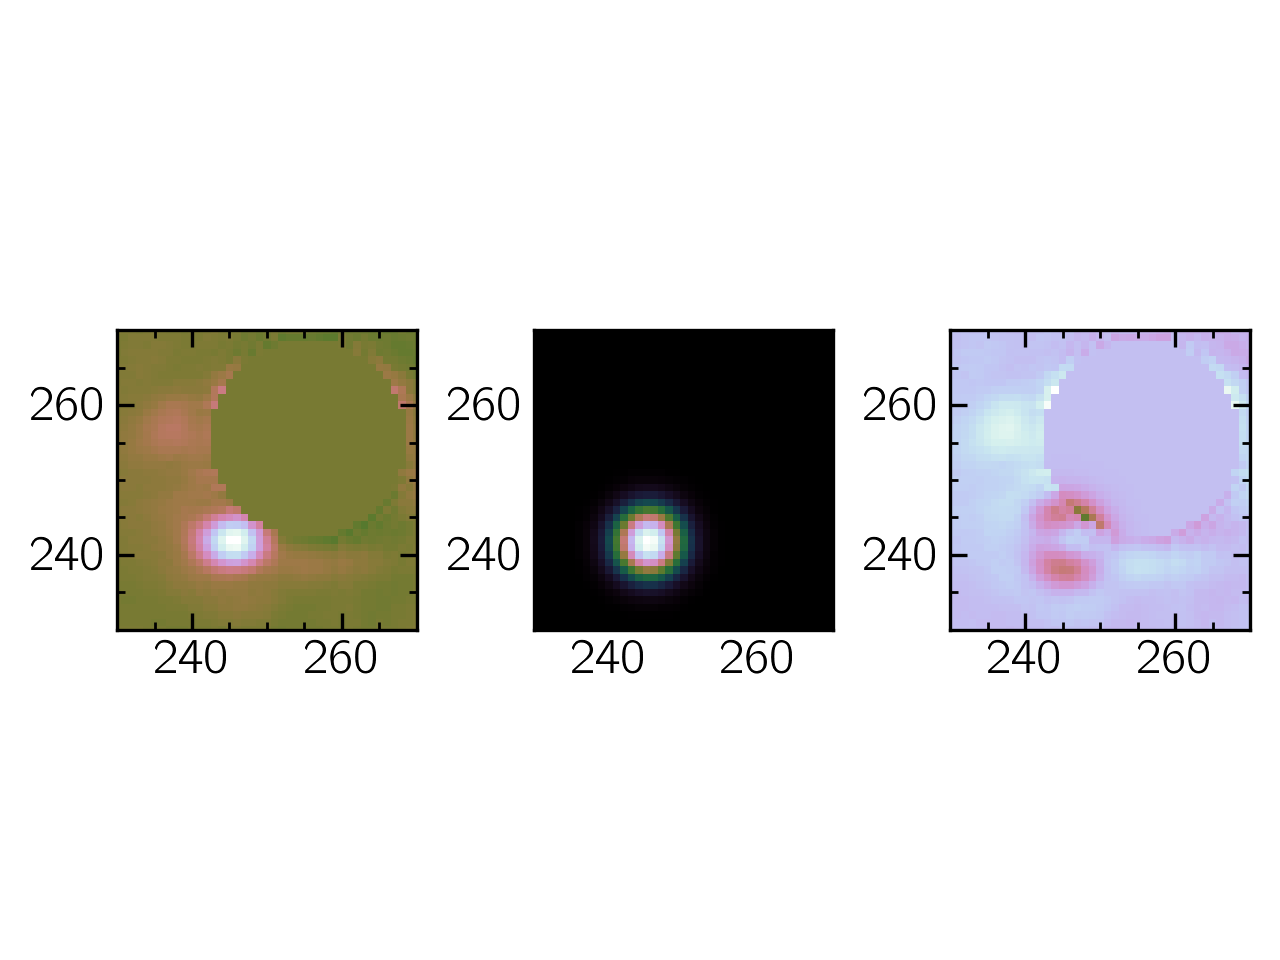

In [21]:
pos = np.array([np.mean(samples[1000:,:,0]),np.mean(samples[1000:,:,1]),
                np.mean(samples[1000:,:,2]),np.mean(samples[1000:,:,3]),
                np.mean(samples[1000:,:,4]),np.mean(samples[1000:,:,4]),
                np.mean(samples[1000:,:,6])])
C_model = ComputeModel(pos)

%matplotlib notebook
cmap = 'cubehelix'
plt.subplot(131)
plt.imshow(im_masked, cmap = cmap)
plt.xlim(230,270)
plt.ylim(230,270)
plt.subplot(132)
plt.imshow(C_model, cmap = cmap)
plt.xlim(230,270)
plt.ylim(230,270)
plt.subplot(133)
plt.imshow(im_masked - C_model, cmap = cmap)
plt.xlim(230,270)
plt.ylim(230,270)
plt.tight_layout()


In [13]:
# Location of A in pixels:
emcee_samples_A = pickle.load(open('MagAOX_HIP67506Aposition_MCMC_chains.pkl','rb'))

# Location of C in pixels:
emcee_samples = pickle.load(open('MagAOX_companionposition_MCMC_chains_5000steps.pkl','rb'))
xcc, ycc = np.mean(emcee_samples[1000:,:,0]),np.mean(emcee_samples[1000:,:,1])
#print(xcc,ycc)


pixscale = 6 #mas/pixel

# Box size for zooming in plots on stars:
box = 30

xccarray, yccarray = emcee_samples[1000:,:,0].flatten(),emcee_samples[1000:,:,1].flatten()
xcaarray, ycaarray = emcee_samples_A[1000:,:,0].flatten(),emcee_samples_A[1000:,:,1].flatten()

rho_pix = np.sqrt( (xcaarray-xccarray)**2 + (ycaarray-yccarray)**2 ) # sep in pixels
rho_mas = rho_pix * pixscale

dx,dy = (xcaarray-xccarray),(ycaarray-yccarray)

pa = np.degrees(np.arctan2(dx,-dy))

print('MCMC std dev:')
print(np.mean(rho_mas),np.std(rho_mas))
print(np.mean(pa),np.std(pa))


from myastrotools.tools import MonteCarloIt
xcc, ycc = [np.mean(xccarray),np.std(xccarray)], [np.mean(yccarray),np.std(yccarray)]
print(xcc,ycc)
xcc[1] = np.sqrt(xcc[1]**2 + 0.5**2)
ycc[1] = np.sqrt(ycc[1]**2 + 0.5**2)
xccarray = MonteCarloIt(xcc,xcaarray.shape)
yccarray = MonteCarloIt(ycc,ycaarray.shape)

rho_pix = np.sqrt( (xcaarray-xccarray)**2 + (ycaarray-yccarray)**2 ) # sep in pixels
rho_mas = rho_pix * pixscale

dx,dy = (xcaarray-xccarray),(ycaarray-yccarray)

pa = np.degrees(np.arctan2(dx,-dy))

print('With pixel error in quad:')
print(np.mean(rho_mas),np.std(rho_mas))
print(np.mean(pa),np.std(pa))

MCMC std dev:
102.91171549673919 0.013886331989130866
143.44759990115307 0.008760056167422727
[245.2884926397915, 0.0027713506541544395] [241.72749296922964, 0.002088529715091769]
With pixel error in quad:
102.94484546174513 2.9984616389108933
143.45049217479712 1.6702631509079569


In [17]:
from astropy.time import Time
t = Time('2022-04-18T00:00:00.1', scale='utc')
t.decimalyear

2022.2931506881025

In [21]:
dist = 221
np.mean(rho_mas/1000 * 221)

22.743489124779355

# Apply pixelscale and rotation correction:

In [16]:
xccarray, yccarray = emcee_samples[1000:,:,0].flatten(),emcee_samples[1000:,:,1].flatten()
xcaarray, ycaarray = emcee_samples_A[1000:,:,0].flatten(),emcee_samples_A[1000:,:,1].flatten()
dx,dy = (xcaarray-xccarray),(ycaarray-yccarray)

scale_shear_matrix_camsci1 = np.array([[ 5.86729064,  0.0424712 ],[ 0.08761152, -5.92269387]])
scale_shear_matrix_camsci1_uncert = np.array([[0.01037503, 0.06179739],[0.06251783, 0.00631883]])

scale_shear_matrix_camsci2 = np.array([[+5.848, +0.03236],[+0.08973, -5.925]])
scale_shear_matrix_camsci2_uncert = np.array([[0.0103, 0.0871],[0.0888, 0.0169]])


In [19]:
scale_shear_matrix_camsci1_array11 = MonteCarloIt([scale_shear_matrix_camsci1[0][0],
                                                  scale_shear_matrix_camsci1_uncert[0][0]],dx.shape[0])
scale_shear_matrix_camsci1_array12 = MonteCarloIt([scale_shear_matrix_camsci1[0][1],
                                                  scale_shear_matrix_camsci1_uncert[0][1]],dx.shape[0])
scale_shear_matrix_camsci1_array21 = MonteCarloIt([scale_shear_matrix_camsci1[1][0],
                                                  scale_shear_matrix_camsci1_uncert[1][0]],dx.shape[0])
scale_shear_matrix_camsci1_array22 = MonteCarloIt([scale_shear_matrix_camsci1[1][1],
                                                  scale_shear_matrix_camsci1_uncert[1][1]],dx.shape[0])

dx_mas = dx*scale_shear_matrix_camsci1_array11 + dy*scale_shear_matrix_camsci1_array12
dy_mas = dx*scale_shear_matrix_camsci1_array21 + dy*scale_shear_matrix_camsci1_array22
np.mean(dx_mas),np.mean(dy_mas)

(60.51789090814733, -80.71021523291175)

In [22]:
rho_mas = np.sqrt( (dx_mas)**2 + (dy_mas)**2 )
np.mean(rho_mas),np.std(rho_mas)

(100.88198325366183, 0.7279651994290792)

In [27]:
pa = np.degrees(np.arctan2(dx_mas,dy_mas))
rotoff_array = MonteCarloIt([1.995,0.61],pa.shape[0])
pa = pa + rotoff_array

np.mean(pa),np.std(pa)

(145.1332011124059, 0.7576032117559258)